In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
from google.cloud import bigquery
project_id = "google.com:datcom-store-dev"
client = bigquery.Client(project=project_id)

In [0]:
obs_cols = [
  'id', 'prov_id', 'is_public', 'observed_node_key', 'start_time_us',
  'end_time_us', 'duration', 'measured_prop', 'sum_value', 'min_value',
  'max_value', 'mean_value', 'median_value', 'measured_value', 'p10',
  'p25', 'p75', 'p90', 'unit', 'sample_size', 'margin_of_error',
  'std_error', 'mean_std_error', 'measurement_method', 'observation_date',
  'observation_period', 'measurement_result', 'growth_rate', 'fake_date',
  'compared_node_key', 'type', 'comparison_operator',
  'std_deviation_value', 'location_key', 'measurement_denominator',
  'scaling_factor', 'measurement_qualifier'
]

In [0]:
# Specify the DCID of your StatisticalVariable
statvar_id = "US_PPI_Meats"

In [0]:
# Define your axes
x = "observation_date"
y = "measured_value"
sort_x = True
group = ""

In [0]:
triples_query = f'SELECT * FROM `google.com:datcom-store-dev.dc_v3_dev.Triple` WHERE subject_id = "{statvar_id}"'
triples = client.query(triples_query).to_dataframe().drop_duplicates(subset=["predicate"])
triples

,id,prov_id,is_public,subject_id,predicate,object_id,object_value,fake_date
0,t/250389652100843742,dc/wchndb2,True,US_PPI_Meats,name,None,US_PPI_Meats,None
1,t/14128377579475308977,dc/wchndb2,True,US_PPI_Meats,unit,IndexPointBasePeriod1982=100,None,None
2,t/2486014342233663456,dc/wchndb2,True,US_PPI_Meats,typeOf,StatisticalVariable,None,None
3,t/16627450261899260064,dc/wchndb2,True,US_PPI_Meats,statType,measuredValue,None,None
4,t/16246235064665644342,dc/wchndb2,True,US_PPI_Meats,commodity,Meats,None,None
5,t/4163463512756770554,dc/wchndb2,True,US_PPI_Meats,populationType,ConsumerGoodsAndServices,None,None
6,t/1838359761150004002,dc/wchndb2,True,US_PPI_Meats,measuredProperty,price,None,None
7,t/7794016805513523985,dc/wchndb2,True,US_PPI_Meats,localCuratorLevelId,None,dcid:US_PPI_Meats,None


In [0]:
ignore = set(["localCuratorLevelId", "name", "statType", "typeOf", "populationType"])
col_mappings = {
    "measuredProperty": "measured_prop", "measurementMethod": "measurement_method",
    "measurementQualifier": "measurement_qualifier", "unit": "unit"
}
pop = triples[triples.predicate == "populationType"].object_id.values[0]

In [0]:
# Narrow down the series
conjunction_dict = {}
values = set()
for _, row in triples.iterrows():
  prop = row["predicate"]
  if prop in ignore:
    continue
  if prop not in col_mappings:
    values.add(row["object_id"])
    continue
  conjunction_dict[col_mappings[prop]] = row["object_id"]

print(conjunction_dict)
print(values)

{'unit': 'IndexPointBasePeriod1982=100', 'measured_prop': 'price'}
{'Meats'}


In [0]:
pop_query = f'SELECT * FROM `google.com:datcom-store-dev.dc_v3_dev.StatisticalPopulation` WHERE population_type = "{pop}"'
print(pop_query)

SELECT * FROM `google.com:datcom-store-dev.dc_v3_dev.StatisticalPopulation` WHERE population_type = "ConsumerGoodsAndServices"


In [0]:
pops = client.query(pop_query).to_dataframe()
pops

,id,prov_id,is_public,population_type,population_group,place_key,num_constraints,p1,v1,p2,v2,p3,v3,p4,v4,p5,v5,p6,v6,p7,v7,p8,v8,p9,v9,p10,v10,fake_date
0,dc/p/49zc584p2zky9,dc/7242lz2,True,ConsumerGoodsAndServices,None,country/USA,1,naics,NAICS/325,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,dc/p/f053rf09fjlxb,dc/7242lz2,True,ConsumerGoodsAndServices,None,country/USA,1,naics,NAICS/484,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,dc/p/3sm9t4ee60m7d,dc/7242lz2,True,ConsumerGoodsAndServices,None,country/USA,1,naics,NAICS/4242,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,dc/p/7nxk1kvfe4r78,dc/7242lz2,True,ConsumerGoodsAndServices,None,country/USA,1,naics,NAICS/4244,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,dc/p/6z7h4vbtjsnbb,dc/7242lz2,True,ConsumerGoodsAndServices,None,country/USA,1,naics,NAICS/33441,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,dc/p/ext9z5xccbkcf,dc/wchndb2,True,ConsumerGoodsAndServices,None,country/USA,1,commodity,MachineryAndEquipmentAndPartsAndSuppliesWholes...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
63,dc/p/v8mpb902tlvkf,dc/wchndb2,True,ConsumerGoodsAndServices,None,country/USA,1,commodity,SecuritiesBrokerageDealingInvestmentAdviceAndR...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
64,dc/p/0xt287tyh64cd,dc/4djvte1,True,ConsumerGoodsAndServices,None,country/USA,1,consumer,UrbanConsumer,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
65,dc/p/0xt287tyh64cd,dc/l92pvl1,True,ConsumerGoodsAndServices,None,country/USA,1,consumer,UrbanConsumer,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [0]:
pop_id = None
values_to_test = set()
for _, row in pops.iterrows():
  if not values:
    found = True
    for i in range(1, 11):
      if row[f"p{i}"]:
        found = False
    if found:
      pop_id = row["id"]
      break
  
  values_to_test.clear()
  for i in range(1, 11):
    if row[f"p{i}"]:
      values_to_test.add(row[f"v{i}"])
  if values == values_to_test:
    pop_id = row["id"]
    break

if pop_id:
  conjunction_dict["observed_node_key"] = pop_id
  print(pop_id)

dc/p/z5zjz3gvedw6f


In [0]:
where = ""
for i, col_val in enumerate(conjunction_dict.items()):
  col, val = col_val
  if not where:
    where = "WHERE "
  where += col + " = " + f'"{val}" '
  if i != len(conjunction_dict) - 1:
    where += "AND "
print(where)

WHERE unit = "IndexPointBasePeriod1982=100" AND measured_prop = "price" AND observed_node_key = "dc/p/z5zjz3gvedw6f" 


In [0]:
query = 'SELECT * FROM `google.com:datcom-store-dev.dc_v3_dev.Observation` ' + where
print(query)

SELECT * FROM `google.com:datcom-store-dev.dc_v3_dev.Observation` WHERE unit = "IndexPointBasePeriod1982=100" AND measured_prop = "price" AND observed_node_key = "dc/p/z5zjz3gvedw6f" 


In [0]:
obs = client.query(query).to_dataframe()
if sort_x:
  obs.sort_values(by=x, inplace=True)
obs.head()

,id,prov_id,is_public,observed_node_key,start_time_us,end_time_us,duration,measured_prop,sum_value,min_value,max_value,mean_value,median_value,measured_value,p10,p25,p75,p90,unit,sample_size,margin_of_error,std_error,mean_std_error,measurement_method,observation_date,observation_period,measurement_result,growth_rate,fake_date,compared_node_key,type,comparison_operator,std_deviation_value,location_key,measurement_denominator,scaling_factor,measurement_qualifier
125,dc/o/mzc2m3dd6cbec,dc/wchndb2,True,dc/p/z5zjz3gvedw6f,None,None,None,price,None,None,None,None,None,13.6,None,None,None,None,IndexPointBasePeriod1982=100,None,None,None,None,None,1939-03,None,None,None,None,None,Observation,None,None,None,None,None,None
919,dc/o/xtkl1zvdh7lcg,dc/wchndb2,True,dc/p/z5zjz3gvedw6f,None,None,None,price,None,None,None,None,None,13.0,None,None,None,None,IndexPointBasePeriod1982=100,None,None,None,None,None,1939-06,None,None,None,None,None,Observation,None,None,None,None,None,None
65,dc/o/qxjfc8rhkdfc8,dc/wchndb2,True,dc/p/z5zjz3gvedw6f,None,None,None,price,None,None,None,None,None,12.8,None,None,None,None,IndexPointBasePeriod1982=100,None,None,None,None,None,1939-08,None,None,None,None,None,Observation,None,None,None,None,None,None
604,dc/o/rl1yd34jcfhv4,dc/wchndb2,True,dc/p/z5zjz3gvedw6f,None,None,None,price,None,None,None,None,None,14.7,None,None,None,None,IndexPointBasePeriod1982=100,None,None,None,None,None,1939-09,None,None,None,None,None,Observation,None,None,None,None,None,None
711,dc/o/ry6ztk2lr2dd6,dc/wchndb2,True,dc/p/z5zjz3gvedw6f,None,None,None,price,None,None,None,None,None,11.8,None,None,None,None,IndexPointBasePeriod1982=100,None,None,None,None,None,1939-12,None,None,None,None,None,Observation,None,None,None,None,None,None


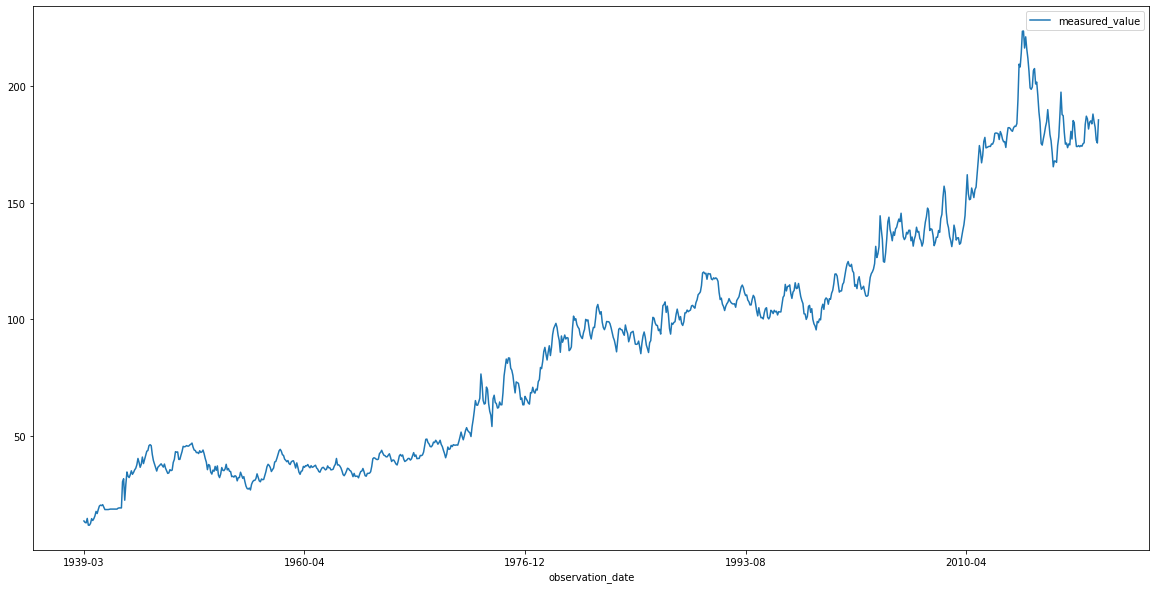

In [0]:
if group:
  obs.groupby(by=group).plot(x=x, y=y, figsize=(20, 10))
else:  
  obs.plot(x=x, y=y, figsize=(20, 10))